## RNNs MNIST

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

#print(os.listdir("../input"))

In [4]:
# Importing the dataset
BATCH_SIZE = 64

# list all transformations
transform = transforms.Compose([transforms.ToTensor()])

# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

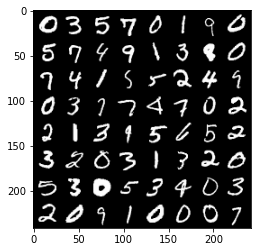

In [37]:
# Exploring the dataset

# functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [46]:
# RNN Model
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super(ImageRNN, self).__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        print(X.size())

        # transforms X to dimensions: n_steps by batch_size by n_inputs
        X = X.permute(1, 0, 2) 

        print("permute step", X.size())
        
        self.batch_size = X.size(1) #which is 64 
        self.hidden = self.init_hidden()

        print("self hidden size", self.hidden.size())
        
        print("\n OUTPUT")
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      

        #basic_rnn takes in 

        print("lstm out", lstm_out.size())
        print("self.hidden size", self.hidden.size())

        out = self.FC(self.hidden)

        print("out", self.FC(self.hidden).size())
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [48]:
# parameters 
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

# Instantiate model
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
#print(logits[0:10])

torch.Size([64, 28, 28])
permute step torch.Size([28, 64, 28])
self hidden size torch.Size([1, 64, 150])

 OUTPUT
lstm out torch.Size([28, 64, 150])
self.hidden size torch.Size([1, 64, 150])
out torch.Size([1, 64, 10])


In [40]:
images.view(-1, 28,28).size()

torch.Size([64, 28, 28])

In [41]:
logits = model(images.view(-1, 28,28))
print(logits.size())

torch.Size([64, 28, 28])
permute step torch.Size([28, 64, 28])
selfhiddensize torch.Size([1, 64, 150])
lstmout torch.Size([28, 64, 150])
self.hidensize torch.Size([1, 64, 150])
torch.Size([64, 10])


In [34]:
# Training
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.7400 | Train Accuracy: 75.94


KeyboardInterrupt: 

In [ ]:
# Calculate test accuracy
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))